In [1]:
from helpers import *
from lstmHelpers import *

import random
from random import randrange, shuffle
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
import time
from collections import deque
import pickle


filedir = "../"

Using TensorFlow backend.


In [2]:
## WRITE STREAM DATA TO FILE
start = time.time()
total_time = time.time()

NUM_QUERY_FILES = 50  # If 0, use ALL classes; else, use n classes only
num_files_in_stream = 30 * NUM_QUERY_FILES
order_to_use = []

used_classes, unused_classes = load_classes(filedir, NUM_QUERY_FILES, display=False)

for i in range(NUM_QUERY_FILES):
    order_to_use.extend([i] * int(num_files_in_stream / NUM_QUERY_FILES))
    
shuffle(order_to_use)
generate_data_file("trainingInfo.txt", filedir, used_classes, unused_classes, order_to_use, max_ramp_length=0.25)
shuffle(order_to_use)
generate_data_file("testingInfo.txt", filedir, used_classes, unused_classes, order_to_use, max_ramp_length=0.25)

# code you want to evaluate
end = time.time()
print("Time elapsed: " + str(end-start) + " seconds, or " + str((end-start)/60.0) + " minutes")

Using classes...
Exact Classes: [6196, 8739, 8969, 3102, 2230, 6069, 3945, 9340, 5807, 3919, 9051, 8125, 3594, 2003, 8592, 7834, 3367, 4843, 4253, 2761, 1314, 698, 4774, 7324, 472, 8938, 1193, 2236, 4128, 5893, 4665]
Matched Classes: [1681, 1327, 1601, 3020, 1914, 2423, 4151, 3006, 548, 251, 2309, 1286, 1240, 1620, 1917, 1376, 2758, 2112, 1165]


Time elapsed: 0.03561973571777344 seconds, or 0.0005936622619628906 minutes


In [4]:
## READ STREAM DATA FROM FILE

def generate_composite_stream(audio_matrix, data_dict = None):
    cur_percentage = 0
    if data_dict == None:
        data_dict = {}
    
    composite_signal_list = []
    composite_matches_list = []
    
    for i in range(len(audio_matrix)):
        if (round(i / len(audio_matrix) * 100) != cur_percentage):
            cur_percentage = round(i / len(audio_matrix) * 100)
            print(str(cur_percentage) + "%     ", end='')
            
        filename = audio_matrix[i][2]
        if filename in data_dict:
            y = data_dict.get(filename)
        else:
            yt,sr = librosa.load(filename)
            y, idx = librosa.effects.trim(yt, top_db=50)
            data_dict[filename] = y
        warped_y = timewarp(y, audio_matrix[i][6])
        noisey_y = apply_noise(warped_y, audio_matrix[i][5])
        faded_y = apply_ramp(noisey_y, audio_matrix[i][3], audio_matrix[i][4])
        composite_signal_list.append(faded_y)
        composite_matches_list.append(np.full(faded_y.shape, audio_matrix[i][1]))
    composite_signal = np.array(composite_signal_list)
    composite_signal = np.concatenate(composite_signal).ravel()
    composite_matches = np.array(composite_matches_list)
    composite_matches = np.concatenate(composite_matches).ravel()
    return composite_signal, composite_matches, data_dict
    
start = time.time()

audio_matrix = load_stream(name="trainingInfo.txt")
composite_signal, composite_matches, preloaded_data = generate_composite_stream(audio_matrix)
audio_matrix_test = load_stream(name="testingInfo.txt")
composite_signal_test, composite_matches_test, x = generate_composite_stream(audio_matrix_test, data_dict=preloaded_data)

audio_matrix = []
audio_matrix_test = []
preloaded_data = {}

NUM_CLASSES_USED = len(set(composite_matches))

end = time.time()
print("\nTime elapsed: " + str(end-start) + " seconds, or " + str((end-start)/60.0) + " minutes")



1%     2%     3%     4%     5%     6%     7%     8%     9%     10%     11%     12%     13%     14%     15%     16%     17%     18%     19%     20%     21%     22%     23%     24%     25%     26%     27%     28%     29%     30%     31%     32%     33%     34%     35%     36%     37%     38%     39%     40%     41%     42%     43%     44%     45%     46%     47%     48%     49%     50%     51%     52%     53%     54%     55%     56%     57%     58%     59%     60%     61%     62%     63%     64%     65%     66%     67%     68%     69%     70%     71%     72%     73%     74%     75%     76%     77%     78%     79%     80%     81%     82%     83%     84%     85%     86%     87%     88%     89%     90%     91%     92%     93%     94%     95%     96%     97%     98%     99%     100%     

1%     2%     3%     4%     5%     6%     7%     8%     9%     10%     11%     12%     13%     14%     15%     16%     17%     18%     19%     20%     21%     22%     23%     24%     25%     26%     27%  

start = time.time()
n_mels = 128
seq_length = 10

def batch(signal, matches, hop_length = 512/8):
    signal_batch_length = 2048*3
    data = []
    classes = []
    
    batched_frames = []
    cur_frame_count = 0
    cur_percentage = 0
    num_to_add  = signal_batch_length
    while cur_frame_count < len(signal):
        batched_frames.extend(signal[cur_frame_count : cur_frame_count + num_to_add - 1])
        recent_signal = np.asarray(batched_frames)
        recent_signal = np.pad(recent_signal, (0, 1024), 'constant', constant_values=(0.0,0.0))
        spec = get_spectrogram(recent_signal, 22050, n_mels=n_mels, display=False)
        cur_col = 0
        transposed = spec.T
        scaler = MinMaxScaler(feature_range=(0, 1))
        transposed = scaler.fit_transform(transposed)
        comp_cols = []
        for i in range(0,seq_length):
            comp_cols.append(transposed[cur_col + i])
        data.append(comp_cols)
        classes.append(int(matches[cur_frame_count-1]))
        batched_frames = batched_frames[int(hop_length)-1:]  # hop length of spectrogram / 8
        
        if (round((cur_frame_count-1) / len(signal) * 100) != cur_percentage):
            cur_percentage = round((cur_frame_count-1) / len(signal) * 100)
            print(str(cur_percentage) + "%     ", end='')
            
        cur_frame_count += num_to_add
        num_to_add = int(hop_length)
        
    return data, classes

def batch_deprecated(signal, matches):
    # Generate batched data list for signal/matches
    data = []
    classes = []
    
    spec = get_spectrogram(signal, 22050, n_mels=n_mels, display=False)
    cur_col = 0
    transposed = spec.T
    scaler = MinMaxScaler(feature_range=(0, 1))
    transposed = scaler.fit_transform(transposed)
    cur_percentage = 0
    for col in transposed:
        if cur_col + batch_length >= len(transposed):
            break
        if (round(cur_col / len(transposed) * 100) != cur_percentage):
            cur_percentage = round(cur_col / len(transposed) * 100)
            print(str(cur_percentage) + "%     ", end='')
        comp_cols = [col]
        for i in range(1,seq_length):
            comp_cols.append(transposed[cur_col + i])
        data.append(comp_cols)
        classes.append(int(matches[int(cur_col / len(transposed) * len(matches))]))
        cur_col += 1
    return data, classes

print("Training Data")
training_data, training_classes = batch(composite_signal, composite_matches)
print()
max_spec_length = len(training_data[0])
print()
training_data = np.array(training_data)

end = time.time()
print("Time elapsed: " + str(end-start) + " seconds, or " + str((end-start)/60.0) + " minutes")

# Make/test the LSTM

lstm_out = 350
batch_size = 32
embedding_vector_length = 32
dropout = 0.1
dropout_r = 0.1

number_inputs = NUM_CLASSES_USED

print(str(number_inputs) + " " + str(embedding_vector_length) + " " + str(len(training_data[0])) + " " + str(dropout) + 
      " " + str(lstm_out) + " " + str(dropout_r) + " " + str(NUM_CLASSES_USED))
    
model = Sequential()
model.add(LSTM(lstm_out, input_shape=(batch_length, n_mels), dropout = dropout, recurrent_dropout = dropout_r))
model.add(Dense(NUM_CLASSES_USED,activation='softmax'))  #softmax
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])  # sparse_categorical_crossentropy
print(model.summary())

model.fit(training_data, training_classes, epochs=4, batch_size=batch_size)

total_end = time.time()
print("Total Time elapsed: " + str((total_end-total_time)/60.0) + " minutes")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 350)               670600    
_________________________________________________________________
dense_4 (Dense)              (None, 50)                17550     
Total params: 688,150
Trainable params: 688,150
Non-trainable params: 0
_________________________________________________________________
None
Training Data: 0 / 36506112 ~= 0%
Epoch 1/4
 - 4s - loss: 2.5393 - acc: 0.1932
Epoch 2/4
 - 3s - loss: 1.8094 - acc: 0.4165
Epoch 3/4
 - 3s - loss: 0.9741 - acc: 0.7019
Epoch 4/4
 - 3s - loss: 0.5571 - acc: 0.8369
Training Data: 640000 / 36506112 ~= 2%
Epoch 1/4
 - 3s - loss: 2.0762 - acc: 0.4137
Epoch 2/4
 - 3s - loss: 0.8836 - acc: 0.7590
Epoch 3/4
 - 3s - loss: 0.5181 - acc: 0.8622
Epoch 4/4
 - 3s - loss: 0.3351 - acc: 0.9138
Training Data: 1280000 / 36506112 ~= 4%
Epoch 1/4
 - 3s - loss: 1.4010 - acc: 0.6246
Epoch 2/4

No handles with labels found to put in legend.


Time elapsed: 2309.9647133350372 seconds, or 38.49941188891729 minutes


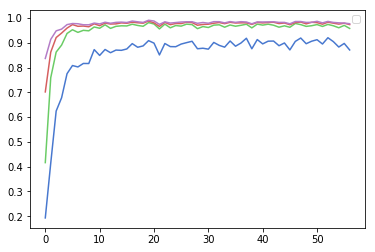

In [8]:
## MINI-BATCH TESTING CELL

def batch(signal, matches, hop_length = 512/8, print_output=False):
    signal_batch_length = 2048*3
    data = []
    classes = []
    
    batched_frames = []
    cur_frame_count = 0
    cur_percentage = 0
    num_to_add  = signal_batch_length
    while cur_frame_count < len(signal):
        batched_frames.extend(signal[cur_frame_count : cur_frame_count + num_to_add - 1])
        recent_signal = np.asarray(batched_frames)
        recent_signal = np.pad(recent_signal, (0, 2048), 'constant', constant_values=(0.0,0.0))
        spec = get_spectrogram(recent_signal, 22050, n_mels=n_mels, display=False)
        cur_col = 0
        transposed = spec.T
        scaler = MinMaxScaler(feature_range=(0, 1))
        transposed = scaler.fit_transform(transposed)
        comp_cols = []
        for i in range(0,seq_length):
            comp_cols.append(transposed[cur_col + i])
        data.append(comp_cols)
        classes.append(int(matches[cur_frame_count-1]))
        batched_frames = batched_frames[int(hop_length)-1:]  # hop length of spectrogram / 8
        
        if print_output and round((cur_frame_count-1) / len(signal) * 100) != cur_percentage:
            cur_percentage = round((cur_frame_count-1) / len(signal) * 100)
            print(str(cur_percentage) + "%     ", end='')
            
        cur_frame_count += num_to_add
        num_to_add = int(hop_length)
        
    return data, classes

start = time.time()
n_mels = 128
seq_length = 10

start_point = 0
batch_length = 10000  # In # of sequences
audio_window= 64
batch_window = batch_length * audio_window

lstm_out = 350
batch_size = 32
embedding_vector_length = 32
dropout = 0.1
dropout_r = 0.1
number_inputs = NUM_CLASSES_USED

model = Sequential()
model.add(LSTM(lstm_out, input_shape=(seq_length, n_mels), dropout = dropout, recurrent_dropout = dropout_r))
model.add(Dense(NUM_CLASSES_USED,activation='softmax'))  #softmax
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])  # sparse_categorical_crossentropy
print(model.summary())

composite_signal_length = len(composite_signal)

acc_0 = []
acc_1 = []
acc_2 = []
acc_3 = []

while start_point + batch_window < composite_signal_length:
    print("Training Data: " + str(start_point) + " / " + str(composite_signal_length) + " ~= " + str(round(start_point / composite_signal_length * 100)) + "%")
    training_data, training_classes = batch(composite_signal[start_point:start_point+batch_window], composite_matches[start_point:start_point+batch_window])
    training_data = np.array(training_data)
    history = model.fit(training_data, training_classes, epochs=4, batch_size=batch_size, verbose=0, shuffle=True)
    accuracies = history.history['acc']
    acc_0.append(accuracies[0])
    acc_1.append(accuracies[1])
    acc_2.append(accuracies[2])
    acc_3.append(accuracies[3])
    start_point += batch_window
    
end = time.time()
print("Time elapsed: " + str(end-start) + " seconds, or " + str((end-start)/60.0) + " minutes")

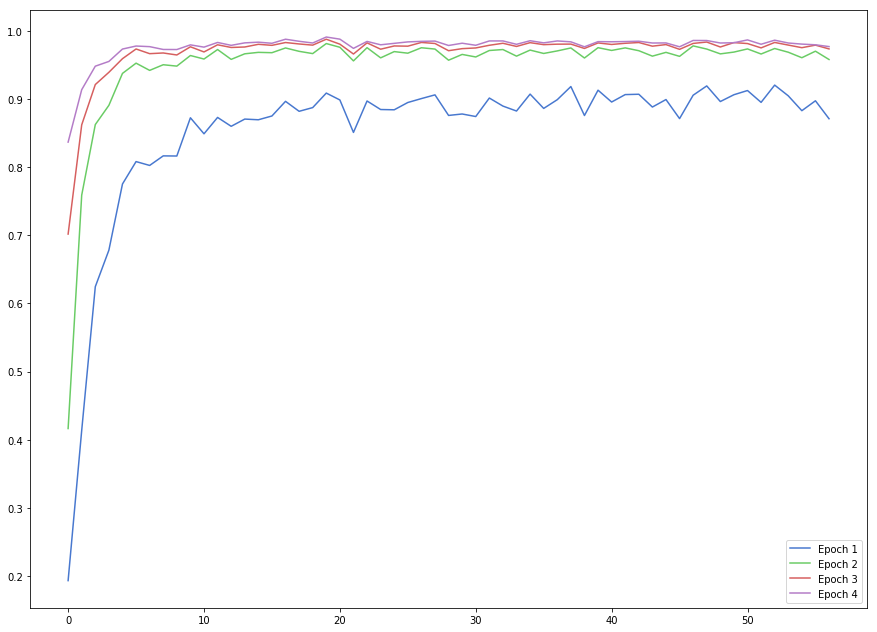

In [13]:
plt.figure(figsize = (15,11))
plt.plot( np.arange(len(acc_0)), acc_0, label='Epoch 1')
plt.plot( np.arange(len(acc_1)), acc_1, label='Epoch 2')
plt.plot( np.arange(len(acc_2)), acc_2, label='Epoch 3')
plt.plot( np.arange(len(acc_3)), acc_3, label='Epoch 4')
plt.legend()

In [14]:
model.save("LSTMModel.h5")

## TESTING NETWORK

print("\nTesting Data")
testing_data, testing_classes = batch(composite_signal_test, composite_matches_test)
testing_data = np.array(testing_data)

scores = model.evaluate(testing_data, testing_classes)
print("Accuracy: %.2f%%" % (scores[1]*100))